# Step 1: Install required libraries

In [46]:
!pip3 install --user pandas numpy


[notice] A new release of pip is available: 25.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [47]:
!pip install --user pandas numpy torch torchvision albumentations matplotlib ultralytics torchmetrics


[notice] A new release of pip is available: 25.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


# Step 2: Import required libraries

In [48]:
import os
import pandas as pd
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.ops import MultiScaleRoIAlign
from collections import OrderedDict
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.image_list import ImageList
from torchvision.ops import boxes as box_ops
from torchvision.ops import clip_boxes_to_image
import math
from ultralytics import YOLO
from torchmetrics.detection import MeanAveragePrecision

# Step 3: Data loading and Preprocessing

In [49]:
DATA_ROOT = '/Users/deepthisivaram/Documents/DL/Final Project/Dataset_RF'
IMG_SIZE = 640
BATCH_SIZE = 8
NUM_WORKERS = 0  

# Define classes
ALL_CLASSES = [
    'Select', 'Button', 'Image', 'Textbox', 'Paragraph',
    'Check Box', 'Radio Button', 'Link', 'Table',
    'Heading', 'Label', 'Carousel', 'Textarea', 'Pagination'
]

### Label Creation

In [50]:
# CLASS_TO_IDX = {cls: idx for idx, cls in enumerate(ALL_CLASSES)}

# def convert_to_yolo_format(row, img_width, img_height):
#     x1, y1, x2, y2 = row["xmin"], row["ymin"], row["xmax"], row["ymax"]
#     cx = (x1 + x2) / 2 / img_width
#     cy = (y1 + y2) / 2 / img_height
#     w = (x2 - x1) / img_width
#     h = (y2 - y1) / img_height
#     class_idx = CLASS_TO_IDX[row["class"]]
#     return f"{class_idx} {cx:.6f} {cy:.6f} {w:.6f} {h:.6f}"

# for split in ["train/images/", "valid/images/", "test/images/"] :
#     csv_path = os.path.join(DATA_ROOT, split, "_annotations.csv")
#     labels_dir = os.path.join(DATA_ROOT, split, "labels")

#     os.makedirs(labels_dir, exist_ok=True)

#     df = pd.read_csv(csv_path)

#     for img_name, group in df.groupby("filename"):
#         img_path = os.path.join(DATA_ROOT, split, img_name)
        
#         if not os.path.exists(img_path):
#             print(f"Warning: Image {img_name} not found in {split}/, skipping...")
#             continue

#         img_width, img_height = group.iloc[0]["width"], group.iloc[0]["height"]
#         label_txt_path = os.path.join(labels_dir, img_name.replace(".jpg", ".txt"))

#         with open(label_txt_path, "w") as f:
#             for _, row in group.iterrows():
#                 yolo_line = convert_to_yolo_format(row, img_width, img_height)
#                 f.write(yolo_line + "\n")

# print("Dataset preprocessing complete. Labels saved in 'train/labels', 'valid/labels', and 'test/labels'.")

### Preprocess

In [51]:
class UISketchDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        
        self.split_dir = os.path.join(root_dir, split)
        self.transform = transform
        self.class_to_idx = {cls: idx for idx, cls in enumerate(ALL_CLASSES)}
        self.idx_to_class = {idx: cls for idx, cls in enumerate(ALL_CLASSES)}
        
        self.annotations = pd.read_csv(
            os.path.join(self.split_dir, '_annotations.csv'),
            dtype={'xmin': int, 'ymin': int, 'xmax': int, 'ymax': int}
        )

        # Strip spaces
        self.annotations['class'] = self.annotations['class'].str.strip()

        # Store image dimensions from CSV
        self.image_sizes = {
            row['filename']: (row['width'], row['height'])
            for _, row in self.annotations.iterrows()
        }

        self._clean_data()
        
        print(f"\n{split.capitalize()} Dataset Stats:")
        print(f"Images: {len(self.image_files)}")
        print(f"Annotations: {len(self.annotations)}")
        print("Class distribution:")
        print(self.annotations['class'].value_counts())

    def _clean_data(self):
        self.annotations = self.annotations[self.annotations['class'].isin(ALL_CLASSES)]
        self.image_files = []
        
        for img_name in self.annotations['filename'].unique():
            img_path = os.path.join(self.split_dir, img_name)
            if os.path.exists(img_path):
                self.image_files.append(img_name)
            else:
                print(f"Warning: Missing image - {img_name}")
        
        self.annotations = self.annotations[self.annotations['filename'].isin(self.image_files)]

    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.split_dir, img_name)

        # Get image dimensions
        w, h = self.image_sizes[img_name]

        try:
            image = cv2.imread(img_path)
            if image is None:
                print(f"Error: Could not load image {img_path}")
                return (
                    torch.zeros((3, IMG_SIZE, IMG_SIZE)),
                    torch.zeros((0, 6))
                )
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Get annotations for the image
            img_anns = self.annotations[self.annotations['filename'] == img_name]
            boxes = img_anns[['xmin', 'ymin', 'xmax', 'ymax']].values
            labels = [self.class_to_idx[cls] for cls in img_anns['class']]

            # Convert to YOLO format
            yolo_boxes = np.array([[
                ((x1 + x2) / 2) / w,   
                ((y1 + y2) / 2) / h,   
                (x2 - x1) / w,         
                (y2 - y1) / h          
            ] for x1, y1, x2, y2 in boxes], dtype=np.float32)

            labels = np.array(labels, dtype=np.int64)

            # Apply transforms
            if self.transform:
                transformed = self.transform(
                    image=image,
                    bboxes=yolo_boxes,
                    class_labels=labels
                )
                image = transformed['image']
                boxes = torch.as_tensor(transformed['bboxes'], dtype=torch.float32)
                labels = torch.as_tensor(transformed['class_labels'], dtype=torch.int64)
            else:
                image = torch.from_numpy(image).permute(2, 0, 1).float() / 255.0
                boxes = torch.as_tensor(yolo_boxes, dtype=torch.float32)
                labels = torch.as_tensor(labels, dtype=torch.int64)

            # Format target for YOLO [image_id, class_id, cx, cy, w, h]
            target = torch.zeros((len(labels), 6))
            target[:, 0] = idx  
            target[:, 1] = labels 
            target[:, 2:6] = boxes

            return image, target

        except Exception as e:
            print(f"Error loading {img_name}: {str(e)}")
            return (
                torch.zeros((3, IMG_SIZE, IMG_SIZE)),
                torch.zeros((0, 6))
            )

In [52]:
def get_yolo_transform(train=True):
    transforms = [
        A.Resize(IMG_SIZE, IMG_SIZE),
        A.Normalize(mean=[0, 0, 0], std=[1, 1, 1]),
        ToTensorV2()
    ]

    if train:
        transforms = [
            A.HorizontalFlip(p=0.5),
            A.RandomBrightnessContrast(p=0.2),
            A.Blur(blur_limit=3, p=0.1),
            A.MedianBlur(blur_limit=3, p=0.1),
            A.ToGray(p=0.1),
            A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=10, p=0.2),
        ] + transforms

    return A.Compose(
        transforms,
        bbox_params=A.BboxParams(
            format='yolo',
            label_fields=['class_labels'],
            min_visibility=0.2
        )
    )

In [53]:
def collate_fn(batch):
    images = []
    targets = []

    for img, target in batch:
        images.append(img)
        targets.append(target)

    images = torch.stack(images, 0)

    for i, target in enumerate(targets):
        if target.shape[0] > 0:
            target[:, 0] = i

    targets = torch.cat(targets, 0)
    return images, targets

### Sample visualization

In [54]:
def visualize_batch(images, targets):
    batch_size = images.shape[0]
    fig, axes = plt.subplots(1, batch_size, figsize=(20, 5))
    
    if batch_size == 1:
        axes = [axes]
    
    images = images.permute(0, 2, 3, 1).cpu().numpy()
    images = np.clip(images, 0, 1)
    
    for i, ax in enumerate(axes):
        ax.imshow(images[i])
        
        img_targets = targets[targets[:, 0] == i]
        
        for target in img_targets:
            _, class_id, cx, cy, w, h = target.tolist()
            
            # Convert YOLO to pixel coordinates
            x1 = int((cx - w/2) * IMG_SIZE)
            y1 = int((cy - h/2) * IMG_SIZE)
            x2 = int((cx + w/2) * IMG_SIZE)
            y2 = int((cy + h/2) * IMG_SIZE)
            
            # Draw bounding box
            rect = plt.Rectangle(
                (x1, y1), x2-x1, y2-y1,
                fill=False, color='red', linewidth=2
            )
            ax.add_patch(rect)
            
            ax.text(
                x1, y1-10, ALL_CLASSES[int(class_id)],
                color='red', fontsize=10, weight='bold'
            )
        
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()


### Data Loader

In [55]:
train_dataset = UISketchDataset(
    root_dir=DATA_ROOT,
    split='train/images/',
    transform=get_yolo_transform(train=True)
)

val_dataset = UISketchDataset(
    root_dir=DATA_ROOT,
    split='valid/images/',
    transform=get_yolo_transform(train=False)
)

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn,
    pin_memory=True
)


Train/images/ Dataset Stats:
Images: 192
Annotations: 3883
Class distribution:
class
Textbox         515
Button          424
Image           408
Link            384
Select          272
Check Box       265
Label           261
Heading         258
Paragraph       231
Radio Button    231
Table           195
Carousel        169
Pagination      150
Textarea        120
Name: count, dtype: int64

Valid/images/ Dataset Stats:
Images: 24
Annotations: 541
Class distribution:
class
Check Box       157
Radio Button     73
Select           65
Link             64
Label            58
Textarea         31
Image            21
Heading          20
Table            19
Paragraph        16
Button            9
Textbox           8
Name: count, dtype: int64


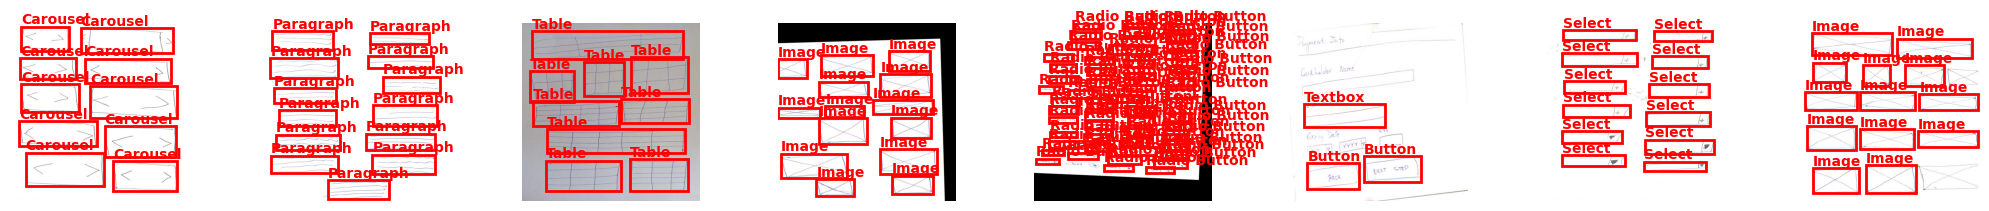

In [56]:
images, targets = next(iter(train_loader))
visualize_batch(images, targets)

# Step 4: Model and training

In [85]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 977.1/977.1 kB 10.9 MB/s eta 0:00:00


In [87]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 960.9/960.9 kB 8.8 MB/s eta 0:00:00


In [30]:
#device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
model = YOLO('yolov8s.pt')

100%|██████████| 21.5M/21.5M [00:00<00:00, 97.1MB/s]


In [33]:
config = {
    'data': '/user/nandhaku/dataset_roboflow/ui_dataset.yaml',
    'imgsz': 640,
    'epochs': 50,
    'batch': 8,
    #'device': 'mps' if torch.backends.mps.is_available() else 'cpu',
    'exist_ok': True,
    'name': 'ui_detection'
}

In [34]:
results = model.train(
    data=config['data'],
    imgsz=config['imgsz'],
    epochs=config['epochs'],
    batch=config['batch'],
    #device=config['device'],
    name=config['name'],
    exist_ok=config['exist_ok']
)

Ultralytics 8.3.101 🚀 Python-3.10.8 torch-2.6.0+cu124 CPU (Intel Xeon Gold 6230 2.10GHz)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/user/nandhaku/dataset_roboflow/ui_dataset.yaml, epochs=50, time=None, patience=100, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=ui_detection, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels

100%|██████████| 755k/755k [00:00<00:00, 12.9MB/s]

Overriding model.yaml nc=80 with nc=14

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytic

  9                  -1  1    656896  ultralytics.nn.modules.block.SPPF            [512, 512, 5]                 
 10                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 11             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 12                  -1  1    591360  ultralytics.nn.modules.block.C2f             [768, 256, 1]                 
 13                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 14             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 15                  -1  1    148224  ultralytics.nn.modules.block.C2f             [384, 128, 1]                 
 16                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
 17            [-1, 12]  1         0  ultralytics.nn.modules.conv.Concat           [1]  

train: Scanning /user/nandhaku/dataset_roboflow/train/labels... 192 images, 0 backgrounds, 0 corrupt: 100%|██████████| 192/192 [00:00<00:00, 1556.48it/s]

train: New cache created: /user/nandhaku/dataset_roboflow/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /user/nandhaku/dataset_roboflow/valid/labels... 24 images, 0 backgrounds, 0 corrupt: 100%|██████████| 24/24 [00:00<00:00, 1465.98it/s]

val: New cache created: /user/nandhaku/dataset_roboflow/valid/labels.cache


Plotting labels to runs/detect/ui_detection/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000556, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/ui_detection
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50         0G      1.489      3.863      1.395        320        640: 100%|██████████| 24/24 [00:51<00:00,  2.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:05<00:05,  5.14s/it]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:08<00:00,  4.39s/it]

                   all         24        541      0.292      0.191      0.155      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50         0G      1.053      2.305       1.07        224        640: 100%|██████████| 24/24 [00:48<00:00,  2.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.76s/it]

                   all         24        541      0.214      0.318       0.23      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50         0G     0.9258      1.678      1.022        172        640: 100%|██████████| 24/24 [00:49<00:00,  2.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.91s/it]

                   all         24        541      0.389      0.556       0.52      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50         0G      0.916      1.598     0.9907        164        640: 100%|██████████| 24/24 [00:47<00:00,  1.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.34s/it]

                   all         24        541      0.446       0.55      0.562      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50         0G     0.8793      1.451     0.9895        406        640: 100%|██████████| 24/24 [00:46<00:00,  1.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]

                   all         24        541      0.478      0.649      0.639      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50         0G     0.8913      1.394     0.9918        211        640: 100%|██████████| 24/24 [00:47<00:00,  1.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.85s/it]

                   all         24        541      0.688      0.588      0.599      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50         0G     0.8386      1.237     0.9678        381        640: 100%|██████████| 24/24 [00:47<00:00,  1.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.42s/it]

                   all         24        541      0.601      0.759       0.72      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50         0G     0.7969      1.135      0.939        280        640: 100%|██████████| 24/24 [00:46<00:00,  1.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.27s/it]

                   all         24        541      0.689      0.747      0.755      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50         0G     0.8171      1.089     0.9568        156        640: 100%|██████████| 24/24 [00:47<00:00,  1.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.30s/it]

                   all         24        541      0.696      0.773      0.805      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50         0G     0.7807     0.9961     0.9376        155        640: 100%|██████████| 24/24 [00:47<00:00,  1.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.35s/it]

                   all         24        541      0.691      0.699      0.735       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50         0G     0.8006     0.9917     0.9464        147        640: 100%|██████████| 24/24 [00:47<00:00,  1.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.43s/it]

                   all         24        541      0.729      0.788      0.828      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50         0G     0.7376     0.9021     0.9339        162        640: 100%|██████████| 24/24 [00:48<00:00,  2.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.30s/it]

                   all         24        541      0.911      0.786      0.898      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50         0G     0.7267     0.8967     0.9459        110        640: 100%|██████████| 24/24 [00:47<00:00,  1.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.23s/it]

                   all         24        541      0.842      0.784      0.875      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50         0G     0.7418     0.8593     0.9254        291        640: 100%|██████████| 24/24 [00:48<00:00,  2.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.06s/it]

                   all         24        541      0.798      0.893      0.928      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50         0G     0.7475     0.8526     0.9428        276        640: 100%|██████████| 24/24 [00:47<00:00,  1.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]

                   all         24        541      0.742      0.875      0.849      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50         0G     0.7761     0.8894     0.9421        169        640: 100%|██████████| 24/24 [00:47<00:00,  1.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]

                   all         24        541      0.878      0.852      0.894       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50         0G     0.7577     0.8373      0.933        272        640: 100%|██████████| 24/24 [00:48<00:00,  2.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]

                   all         24        541      0.825       0.88       0.91      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50         0G     0.7282     0.7949     0.9301        317        640: 100%|██████████| 24/24 [00:48<00:00,  2.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]

                   all         24        541      0.894       0.89      0.937      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50         0G     0.7163     0.7488     0.9211        220        640: 100%|██████████| 24/24 [00:49<00:00,  2.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.16s/it]

                   all         24        541      0.868      0.913       0.95      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50         0G      0.714     0.7577     0.9238        177        640: 100%|██████████| 24/24 [00:46<00:00,  1.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.06s/it]

                   all         24        541      0.918      0.892      0.947      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50         0G     0.7315     0.7342     0.9225        309        640: 100%|██████████| 24/24 [00:46<00:00,  1.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]

                   all         24        541      0.887      0.875      0.931       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50         0G     0.7205     0.7285     0.9226        285        640: 100%|██████████| 24/24 [00:47<00:00,  1.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]

                   all         24        541      0.917       0.91      0.945      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50         0G     0.7005     0.6783     0.9094        205        640: 100%|██████████| 24/24 [00:48<00:00,  2.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]

                   all         24        541      0.937      0.905      0.952      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50         0G     0.6964     0.7018     0.9168        271        640: 100%|██████████| 24/24 [00:48<00:00,  2.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]

                   all         24        541      0.915      0.903       0.95      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50         0G     0.6946     0.6762     0.9128        326        640: 100%|██████████| 24/24 [00:47<00:00,  1.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]

                   all         24        541      0.904      0.938      0.956      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50         0G     0.6886     0.6734     0.9128        282        640: 100%|██████████| 24/24 [00:47<00:00,  1.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]

                   all         24        541      0.932      0.917      0.956      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50         0G     0.6643     0.6413     0.9119        171        640: 100%|██████████| 24/24 [00:48<00:00,  2.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]

                   all         24        541      0.944      0.899      0.953      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50         0G     0.6642     0.6508     0.8948        361        640: 100%|██████████| 24/24 [00:48<00:00,  2.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.06s/it]

                   all         24        541      0.936      0.913      0.954      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50         0G     0.6433     0.6392      0.905        207        640: 100%|██████████| 24/24 [00:49<00:00,  2.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]

                   all         24        541      0.942      0.909      0.949      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50         0G     0.6502     0.5897     0.9012        251        640: 100%|██████████| 24/24 [00:48<00:00,  2.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]

                   all         24        541      0.905      0.895      0.946      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50         0G     0.6532     0.6037     0.8979        178        640: 100%|██████████| 24/24 [00:48<00:00,  2.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]

                   all         24        541      0.931      0.854      0.941      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50         0G     0.6763     0.6275     0.9006        244        640: 100%|██████████| 24/24 [00:48<00:00,  2.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]

                   all         24        541      0.963      0.861      0.949      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50         0G     0.6626     0.5829     0.8976        145        640: 100%|██████████| 24/24 [00:49<00:00,  2.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]

                   all         24        541      0.872      0.919      0.961       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50         0G     0.6529     0.5864      0.904        334        640: 100%|██████████| 24/24 [00:47<00:00,  1.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]

                   all         24        541      0.954      0.934      0.969      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50         0G     0.6343     0.5758     0.8967        193        640: 100%|██████████| 24/24 [00:48<00:00,  2.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]

                   all         24        541      0.927      0.939      0.968      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50         0G     0.6455     0.5872     0.9028        296        640: 100%|██████████| 24/24 [00:47<00:00,  1.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.06s/it]

                   all         24        541      0.922      0.936      0.968      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50         0G     0.6799      0.612     0.9054        237        640: 100%|██████████| 24/24 [00:47<00:00,  1.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.01s/it]

                   all         24        541      0.932      0.941      0.967      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50         0G     0.6465     0.5476     0.8924        175        640: 100%|██████████| 24/24 [00:47<00:00,  1.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.01s/it]

                   all         24        541      0.931      0.941      0.966       0.83



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50         0G     0.6507     0.5709     0.9007        153        640: 100%|██████████| 24/24 [00:47<00:00,  1.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]

                   all         24        541      0.932      0.939      0.965      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50         0G     0.6395     0.5466     0.8967        137        640: 100%|██████████| 24/24 [00:48<00:00,  2.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]

                   all         24        541      0.925      0.939      0.965      0.826


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50         0G     0.5976     0.5471     0.8843        148        640: 100%|██████████| 24/24 [00:45<00:00,  1.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]

                   all         24        541      0.936      0.931      0.966      0.831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50         0G     0.5984      0.531     0.8816        172        640: 100%|██████████| 24/24 [00:46<00:00,  1.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]

                   all         24        541      0.926      0.913      0.955      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50         0G     0.5953     0.5362     0.8752        183        640: 100%|██████████| 24/24 [00:47<00:00,  1.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]

                   all         24        541      0.931      0.906      0.949      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50         0G     0.5998     0.5099     0.8769        159        640: 100%|██████████| 24/24 [00:47<00:00,  1.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]

                   all         24        541      0.896      0.915      0.953      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50         0G     0.5638     0.5001     0.8717        186        640: 100%|██████████| 24/24 [00:47<00:00,  1.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]

                   all         24        541      0.917      0.939      0.961      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50         0G     0.5702     0.5001     0.8759        132        640: 100%|██████████| 24/24 [00:46<00:00,  1.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]

                   all         24        541      0.932       0.92      0.963      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50         0G     0.5706     0.4965     0.8703        184        640: 100%|██████████| 24/24 [00:46<00:00,  1.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]

                   all         24        541      0.927      0.937      0.964      0.836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50         0G     0.5618     0.4878     0.8656        118        640: 100%|██████████| 24/24 [00:47<00:00,  1.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]

                   all         24        541      0.927      0.929      0.964      0.838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50         0G     0.5833     0.5144     0.8864        155        640: 100%|██████████| 24/24 [00:47<00:00,  1.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

### Validation

In [12]:
model = YOLO('/user/nandhaku/dataset_roboflow/runs/detect/ui_detection/weights/best.pt')  

results = model.val()

precision = float(results.box.p.mean()) if isinstance(results.box.p, np.ndarray) else 0.0
recall = float(results.box.r.mean()) if isinstance(results.box.r, np.ndarray) else 0.0

print(f"mAP@50: {results.box.map50:.4f}")
print(f"mAP@50-95: {results.box.map:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Ultralytics 8.3.101 🚀 Python-3.10.8 torch-2.6.0+cu124 CPU (Intel Xeon Gold 6230 2.10GHz)
Model summary (fused): 72 layers, 11,131,002 parameters, 0 gradients, 28.5 GFLOPs


val: Scanning /user/nandhaku/dataset_roboflow/valid/labels.cache... 24 images, 0 backgrounds, 0 corrupt: 100%|██████████| 24/24 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.88s/it]


                   all         24        541      0.953      0.917      0.964      0.841
                Select          5         65      0.918      0.866      0.904      0.803
                Button          8          9      0.904      0.778      0.973      0.899
                 Image          5         21      0.941          1      0.995      0.953
               Textbox          5          8      0.987          1      0.995      0.853
             Paragraph          4         16      0.953      0.688      0.843      0.738
             Check Box          7        157      0.937      0.943      0.954      0.767
          Radio Button          6         73      0.934      0.836       0.96      0.782
                  Link          1         64          1      0.933      0.995      0.721
                 Table          2         19      0.982          1      0.995      0.985
               Heading          3         20      0.986          1      0.995      0.803
                 Labe

### Testing

In [21]:
test_dataset = UISketchDataset(
    root_dir=DATA_ROOT,
    split='test/images/',
    transform=get_yolo_transform(train=False)
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn,
    pin_memory=True
)


Test/images/ Dataset Stats:
Images: 7
Annotations: 158
Class distribution:
class
Check Box    70
Button       32
Textbox      25
Select       14
Carousel      9
Image         8
Name: count, dtype: int64


In [22]:
model = YOLO('/user/nandhaku/dataset_roboflow/runs/detect/ui_detection/weights/best.pt')  

metrics = model.val(
    data='/user/nandhaku/dataset_roboflow/ui_dataset.yaml',
    split='test' 
)

print(f"mAP@50: {results.box.map50:.4f}")
print(f"mAP@50-95: {results.box.map:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Ultralytics 8.3.101 🚀 Python-3.10.8 torch-2.6.0+cu124 CPU (Intel Xeon Gold 6230 2.10GHz)
Model summary (fused): 72 layers, 11,131,002 parameters, 0 gradients, 28.5 GFLOPs


val: Scanning /user/nandhaku/dataset_roboflow/test/labels... 7 images, 0 backgrounds, 0 corrupt: 100%|██████████| 7/7 [00:00<00:00, 1491.50it/s]

val: New cache created: /user/nandhaku/dataset_roboflow/test/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


                   all          7        158      0.893      0.975      0.957      0.868
                Select          1         14          1      0.865      0.995      0.945
                Button          1         32      0.989          1      0.995      0.894
                 Image          1          8      0.961          1      0.995      0.973
               Textbox          1         25      0.736          1      0.933      0.831
             Check Box          2         70      0.708      0.986      0.832      0.629
              Carousel          1          9      0.965          1      0.995      0.938
Speed: 1.3ms preprocess, 95.0ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/detect/val6
mAP@50: 0.9644
mAP@50-95: 0.8408
Precision: 0.9526
Recall: 0.9174


### Visualization of testing results


image 1/1 /user/nandhaku/dataset_roboflow/test/images/image_65_png.rf.e3218cec368b8116517298850b15d964.jpg: 640x640 54 Check Boxs, 125.6ms
Speed: 2.0ms preprocess, 125.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


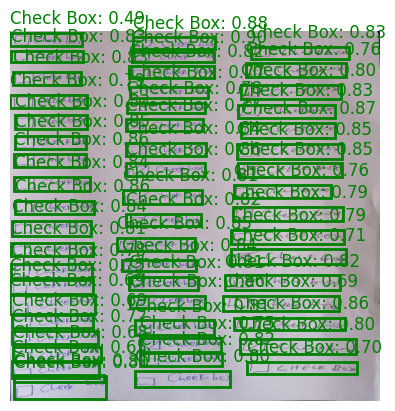

In [3]:
import matplotlib.pyplot as plt
import cv2
from ultralytics import YOLO

model = YOLO('runs/detect/ui_detection/weights/best.pt')

test_image_path = "/user/nandhaku/dataset_roboflow/test/images/image_65_png.rf.e3218cec368b8116517298850b15d964.jpg"

results = model(test_image_path)

image = cv2.imread(test_image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

for result in results:
    for box in result.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        conf = float(box.conf[0])
        cls = int(box.cls[0])

        plt.gca().add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                          linewidth=2, edgecolor='g', facecolor='none'))
        label = f"{model.names[cls]}: {conf:.2f}"

        plt.text(x1, y1 - 10, label, color='green', fontsize=12, ha='left', va='bottom')

plt.imshow(image_rgb)
plt.axis('off')
plt.show()

# Step 5: Convert predictions to HTML


0: 640x640 32 Buttons, 165.2ms
Speed: 2.3ms preprocess, 165.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)



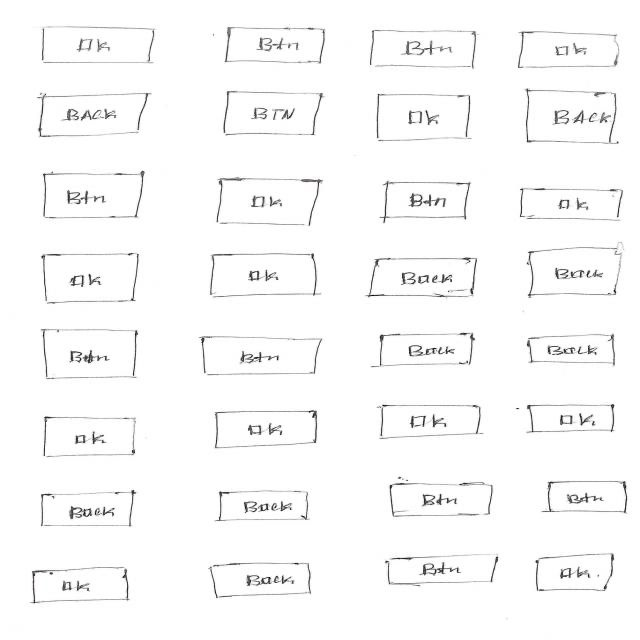

In [35]:
import cv2
import base64
from ultralytics import YOLO
from IPython.display import display, HTML

def ui_elements_to_html(image_path, model_path='/Users/deepthisivaram/Documents/DL/Final Project/best.pt'):
    img = cv2.imread(image_path)
    _, buffer = cv2.imencode('.jpg', img)
    img_str = base64.b64encode(buffer).decode('utf-8')
    
    model = YOLO(model_path)
    results = model.predict(img)
    
    element_templates = {
        'Button': '<button class="ui-button" style="position:absolute; left:{x}px; top:{y}px; width:{w}px; height:{h}px">{text}</button>',
        'Textbox': '<input type="text" class="ui-textbox" style="position:absolute; left:{x}px; top:{y}px; width:{w}px; height:{h}px" placeholder="{text}">',
        'Check Box': '<label class="ui-checkbox" style="position:absolute; left:{x}px; top:{y}px"><input type="checkbox"> {text}</label>',
        'Radio Button': '<label class="ui-radio" style="position:absolute; left:{x}px; top:{y}px"><input type="radio" name="radio-group"> {text}</label>',
        'Paragraph': '<p class="ui-paragraph" style="position:absolute; left:{x}px; top:{y}px; width:{w}px">{text}</p>',
        'Heading': '<h3 class="ui-heading" style="position:absolute; left:{x}px; top:{y}px">{text}</h3>',
        'Select': '<select class="ui-select" style="position:absolute; left:{x}px; top:{y}px; width:{w}px"><option>{text}</option></select>',
        'default': '<div class="ui-element" style="position:absolute; left:{x}px; top:{y}px; width:{w}px; height:{h}px">{text}</div>'
    }
    
    html_elements = []
    for result in results:
        for box in result.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            cls_name = model.names[int(box.cls[0])]
            conf = float(box.conf[0])
            
            template = element_templates.get(cls_name, element_templates['default'])
            html_elements.append(template.format(
                x=x1, y=y1, w=x2-x1, h=y2-y1,
                text=cls_name if conf > 0.5 else f"{cls_name} ({conf:.2f})"
            ))
    
    html = f"""
    <!DOCTYPE html>
    <html>
    <head>
        <title>UI Reconstruction</title>
        <style>
            body {{
                font-family: Arial, sans-serif;
                position: relative;
                margin: 0;
                padding: 0;
                min-height: 100vh;
                background: #f5f5f5;
            }}
            .original-image {{
                position: absolute;
                opacity: 0.3;
                z-index: 0;
                max-width: 100%;
            }}
            .ui-container {{
                position: relative;
                z-index: 1;
                width: {img.shape[1]}px;
                height: {img.shape[0]}px;
                margin: 20px auto;
                background: white;
                box-shadow: 0 0 10px rgba(0,0,0,0.1);
            }}
            .ui-button {{
                background: #4285f4;
                color: white;
                border: none;
                border-radius: 4px;
                padding: 8px 16px;
                cursor: pointer;
            }}
            .ui-textbox {{
                border: 1px solid #ddd;
                padding: 8px;
                border-radius: 4px;
            }}
            .ui-checkbox, .ui-radio {{
                display: flex;
                align-items: center;
                gap: 8px;
            }}
            .ui-heading {{
                color: #333;
                margin: 0;
            }}
            .ui-paragraph {{
                color: #666;
                margin: 0;
                line-height: 1.5;
            }}
            .ui-select {{
                padding: 8px;
                border-radius: 4px;
                border: 1px solid #ddd;
            }}
        </style>
    </head>
    <body>
        <div class="ui-container">
            <img class="original-image" src="data:image/jpg;base64,{img_str}">
            {''.join(html_elements)}
        </div>
    </body>
    </html>
    """
    
    with open("ui_reconstruction.html", "w") as f:
        f.write(html)
    
    return html

html_output = ui_elements_to_html("/Users/deepthisivaram/Downloads//WhatsApp Image 2025-04-28 at 18.53.17.jpeg")
display(HTML(html_output))

In [ ]:
import cv2
import base64
from ultralytics import YOLO
from IPython.display import HTML, display
import easyocr
import numpy as np

reader = easyocr.Reader(['en'])

def generate_ui_from_yolo_and_ocr(image_path, model_path, theme='default'):
    # Load Image
    img = cv2.imread(image_path)
    orig_img = img.copy()

    # YOLO Detection
    model = YOLO(model_path)
    results = model.predict(img)

    # OCR Detection
    ocr_results = reader.readtext(orig_img)

    # Image to base64
    _, buffer = cv2.imencode('.jpg', orig_img)
    img_str = base64.b64encode(buffer).decode('utf-8')

    # Scaling for display
    display_width = 800
    scale_x = display_width / img.shape[1]
    scale_y = display_width / img.shape[1]

    # Themes
    themes = {
        'default': {
            'background': '#f5f5f5', 'container_bg': 'white',
            'button_bg': '#4285f4', 'button_text': 'white',
            'text_color': '#333', 'paragraph_color': '#666',
            'border_color': '#ddd', 'shadow': '0 0 10px rgba(0,0,0,0.1)',
            'font': 'Arial, sans-serif'
        },
        'warm': {
            'background': '#fff8f0', 'container_bg': '#fffaf5',
            'button_bg': '#e67e22', 'button_text': 'white',
            'text_color': '#5d4037', 'paragraph_color': '#795548',
            'border_color': '#ffccbc', 'shadow': '0 0 10px rgba(230,126,34,0.2)',
            'font': 'Georgia, serif'
        },
        'cold': {
            'background': '#f0f8ff', 'container_bg': '#f5faff',
            'button_bg': '#3498db', 'button_text': 'white',
            'text_color': '#2c3e50', 'paragraph_color': '#34495e',
            'border_color': '#bde0fe', 'shadow': '0 0 10px rgba(52,152,219,0.2)',
            'font': 'Helvetica, Arial, sans-serif'
        },
        'minimal': {
            'background': '#ffffff', 'container_bg': '#ffffff',
            'button_bg': '#000000', 'button_text': 'white',
            'text_color': '#333333', 'paragraph_color': '#666666',
            'border_color': '#eeeeee', 'shadow': 'none',
            'font': 'Roboto, Arial, sans-serif'
        },
        'dark': {
            'background': '#121212', 'container_bg': '#1e1e1e',
            'button_bg': '#bb86fc', 'button_text': '#121212',
            'text_color': '#e0e0e0', 'paragraph_color': '#b0b0b0',
            'border_color': '#333333', 'shadow': '0 0 10px rgba(187,134,252,0.2)',
            'font': 'Inter, Arial, sans-serif'
        }
    }
    current_theme = themes.get(theme.lower(), themes['default'])

    # Template mapping
    element_templates = {
        'Button': '<button class="ui-button" style="position:absolute; left:{x}px; top:{y}px; width:{w}px; height:{h}px">{text}</button>',
        'Textbox': '<input type="text" class="ui-textbox" style="position:absolute; left:{x}px; top:{y}px; width:{w}px; height:{h}px" placeholder="{text}" value="{text}">',
        'Check Box': '<label class="ui-checkbox" style="position:absolute; left:{x}px; top:{y}px"><input type="checkbox"> {text}</label>',
        'Radio Button': '<label class="ui-radio" style="position:absolute; left:{x}px; top:{y}px"><input type="radio" name="radio-group"> {text}</label>',
        'Paragraph': '<p class="ui-paragraph" style="position:absolute; left:{x}px; top:{y}px; width:{w}px">{text}</p>',
        'Heading': '<h3 class="ui-heading" style="position:absolute; left:{x}px; top:{y}px">{text}</h3>',
        'Select': '<select class="ui-select" style="position:absolute; left:{x}px; top:{y}px; width:{w}px"><option>{text}</option></select>',
        'Link': '<a href="#" class="ui-link" style="position:absolute; left:{x}px; top:{y}px">{text}</a>',
        'Label': '<label class="ui-label" style="position:absolute; left:{x}px; top:{y}px">{text}</label>',
        'Image': '<div class="ui-image" style="position:absolute; left:{x}px; top:{y}px; width:{w}px; height:{h}px; background:#eee; display:flex; align-items:center; justify-content:center">{text}</div>',
        'Table': '<div class="ui-table" style="position:absolute; left:{x}px; top:{y}px; width:{w}px; height:{h}px; border:1px solid #ddd">{text}</div>',
        'Carousel': '<div class="ui-carousel" style="position:absolute; left:{x}px; top:{y}px; width:{w}px; height:{h}px; background:#f9f9f9; display:flex; align-items:center; justify-content:center">{text}</div>',
        'Textarea': '<textarea class="ui-textarea" style="position:absolute; left:{x}px; top:{y}px; width:{w}px; height:{h}px">{text}</textarea>',
        'Pagination': '<div class="ui-pagination" style="position:absolute; left:{x}px; top:{y}px; display:flex; gap:5px">{text}</div>',
        'default': '<div class="ui-element" style="position:absolute; left:{x}px; top:{y}px; width:{w}px; height:{h}px">{text}</div>'
    }

    def is_near(x, y, box, padding=20):
        x1, y1, x2, y2 = box
        return (x1 - padding <= x <= x2 + padding) and (y1 - padding <= y <= y2 + padding)

    # Combine YOLO + OCR
    yolo_elements = []
    for result in results:
        for box in result.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            cls_id = int(box.cls[0])
            label = model.names[cls_id]
            yolo_elements.append({'box': (x1, y1, x2, y2), 'label': label, 'text': None})

    for detection in ocr_results:
        (bbox, text, _) = detection
        (top_left, _, bottom_right, _) = bbox
        text_x = int((top_left[0] + bottom_right[0]) / 2)
        text_y = int((top_left[1] + bottom_right[1]) / 2)
        for element in yolo_elements:
            if is_near(text_x, text_y, element['box']):
                element['text'] = text.strip()

    html_elements = []
    for element in yolo_elements:
        x1, y1, x2, y2 = element['box']
        sx = x1 * scale_x
        sy = y1 * scale_y
        sw = (x2 - x1) * scale_x
        sh = (y2 - y1) * scale_y
        label = element['label']
        element_text = element['text'] if element['text'] else label
        template = element_templates.get(label, element_templates['default'])
        html_elements.append(template.format(x=int(sx), y=int(sy), w=int(sw), h=int(sh), text=element_text))

    # Add standalone OCR text
    for detection in ocr_results:
        (bbox, text, _) = detection
        (top_left, _, bottom_right, _) = bbox
        text_x = int((top_left[0] + bottom_right[0]) / 2)
        text_y = int((top_left[1] + bottom_right[1]) / 2)
        if not any(is_near(text_x, text_y, e['box']) for e in yolo_elements):
            sx = text_x * scale_x
            sy = text_y * scale_y
            html_elements.append(
                f'<div style="position:absolute; left:{int(sx)}px; top:{int(sy)}px; font-size:14px; color:{current_theme["text_color"]};">{text}</div>'
            )
    
    html = f"""
    <!DOCTYPE html>
    <html>
    <head>
        <title>UI Reconstruction</title>
        <style>
            body {{
                font-family: Arial, sans-serif;
                position: relative;
                margin: 0;
                padding: 0;
                min-height: 100vh;
                background: #f5f5f5;
            }}
            .original-image {{
                position: absolute;
                opacity: 0.3;
                z-index: 0;
                max-width: 100%;
            }}
            .ui-container {{
                position: relative;
                z-index: 1;
                width: {img.shape[1]}px;
                height: {img.shape[0]}px;
                margin: 20px auto;
                background: white;
                box-shadow: 0 0 10px rgba(0,0,0,0.1);
            }}
            .ui-button {{
                background: #4285f4;
                color: white;
                border: none;
                border-radius: 4px;
                padding: 8px 16px;
                cursor: pointer;
            }}
            .ui-textbox {{
                border: 1px solid #ddd;
                padding: 8px;
                border-radius: 4px;
            }}
            .ui-checkbox, .ui-radio {{
                display: flex;
                align-items: center;
                gap: 8px;
            }}
            .ui-heading {{
                color: #333;
                margin: 0;
            }}
            .ui-paragraph {{
                color: #666;
                margin: 0;
                line-height: 1.5;
            }}
            .ui-select {{
                padding: 8px;
                border-radius: 4px;
                border: 1px solid #ddd;
            }}
        </style>
    </head>
    <body>
        <div class="ui-container">
            {''.join(html_elements)}
        </div>
    </body>
    </html>
    """
    
    with open("ui_reconstruction.html", "w") as f:
        f.write(html)
    
    display(HTML(html))

generate_ui_from_yolo_and_ocr(
    image_path="/Users/deepthisivaram/Downloads/IMG_2940.jpeg",
    model_path="/Users/deepthisivaram/Documents/DL/Final Project/best.pt",
    theme="default"
)



0: 640x480 1 Button, 2 Textboxs, 1 Paragraph, 145.9ms
Speed: 3.6ms preprocess, 145.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


✅ UI with OCR and YOLO saved as 'final_ui_reconstruction.html'
